In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr#;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat,compute_N
from orographicPrecipitation.observationsAndERA5.linearWaveModels import second_derivative_matrix,linear_w_generalized, linear_w_generalized_forced, w_to_Tprime,w_to_qprime,z_to_p_standard
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,k_vector

SCRATCH='/global/cscratch1/sd/qnicolas/'

import scipy.linalg as spl
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from calc_GW_LRF import make_A_damped, coupled_gw_mode_damped, gw_mode_forced_damped

%load_ext autoreload
%autoreload 2

In [2]:
DZ = 100.
zz_full = np.arange(0.,20e3,DZ)
N0=0.01;U0=10;k0=2*np.pi/100e3;hhat0=1.

# Functions

In [3]:
kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")

Mkuang=kuangdata['M']
pres=kuangdata['pres'][:,0]
tmean=kuangdata['tmean'][:,0]
qmean=kuangdata['qmean'][:,0]
zrce = kuangdata['z'][:,0]
zT = zrce[:-2]
zQ = zrce[:14]

#Reverse positive eigenvalue
lambdas,P = spl.eig(Mkuang)
lambdas[5]*=-1
Pm1 = spl.inv(P)
Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

In [4]:
def QcQqfromTq(MM,zM,zforc,forcT,forcq):
    forcT_interp = np.interp(zM,zforc,forcT)[:26]
    forcq_interp = np.interp(zM,zforc,forcq)[:14]
    forcing=np.concatenate((forcT_interp,forcq_interp))
    reps = np.dot(MM,forcing)
    repQc = np.concatenate((reps[:26],[0.,0.]))
    repQq = np.concatenate((reps[26:],np.zeros(14)))
    return np.interp(zforc,zM,repQc,left=0.,right=0.),np.interp(zforc,zM,repQq,left=0.,right=0.)

In [5]:
from calc_GW_LRF import *

In [6]:
g = 9.81
Lv = 2.5e6
cp=1004.
Rd = 287.
T0=300.

In [7]:
class SimulationCustom(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.RAINNC  = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%self.suffix2).RAINNC_MMDY
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
        sample_pout = xr.open_dataset(sorted(glob.glob(self.path+"wrfpout*"))[20])
        Z_all = change_coords_pl(sample_pout,sample_pout.GHT_PL).sel(distance_from_mtn=slice(-2000,-5000))
        self.Z_PL_SNAP = Z_all.where(Z_all>0).mean(['Time','south_north','distance_from_mtn'])
        self.N_PL_MEAN = compute_N(self.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')

#class SimulationCustom(Simulation):
#    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
#        super().__init__(path,center,dx,inp,out,pout,is_subset)
#        self.T_PL_MEAN = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.T_PL_MEAN.nc")
#        self.Q_PL_MEAN = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.Q_PL_MEAN.nc")
#        self.Z_PL_SNAP = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.Z_PL_SNAP.nc")
#        self.N_PL_MEAN = compute_N(self.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')
#        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')
#        self.RAINNC  = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%suffix2).RAINNC_MMDY

W10S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W10S300.N2_full = np.interp(zz_full,W10S300.Z_PL_SNAP,W10S300.N_PL_MEAN)**2
W10S300.dqdz_full = np.interp(zz_full,W10S300.Z_PL_SNAP,np.gradient(W10S300.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP))
W10S300.N2TEST = g/300*(np.gradient(W10S300.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP)+g/cp)
W10S300.N2TEST_full = np.interp(zz_full,W10S300.Z_PL_SNAP,W10S300.N2TEST)

In [8]:
W10S296   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/'          ,1635,3,'1970010100-1970090900',inp=False)
W10S296.N2_full = np.interp(zz_full,W10S296.Z_PL_SNAP,W10S296.N_PL_MEAN)**2
W10S296.dqdz_full = np.interp(zz_full,W10S296.Z_PL_SNAP,np.gradient(W10S296.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S296.Z_PL_SNAP))
W10S296.N2TEST = g/300*(np.gradient(W10S296.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S296.Z_PL_SNAP)+g/cp)
W10S296.N2TEST_full = np.interp(zz_full,W10S296.Z_PL_SNAP,W10S296.N2TEST)

In [9]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

## Sample mode

In [32]:
#kblow = 1.12e-5
kblow=1e-2
eps = 3/86400

In [33]:
w_sampleu =  gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,kblow,hhat0,U0,0.*zz_full)
w_sampleu_damped,Tprime_sampleu_damped,_,_,_  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,eps,0*Mkuang2,coupling='full',itp_matrices=None)

(1010.0, 0.0)

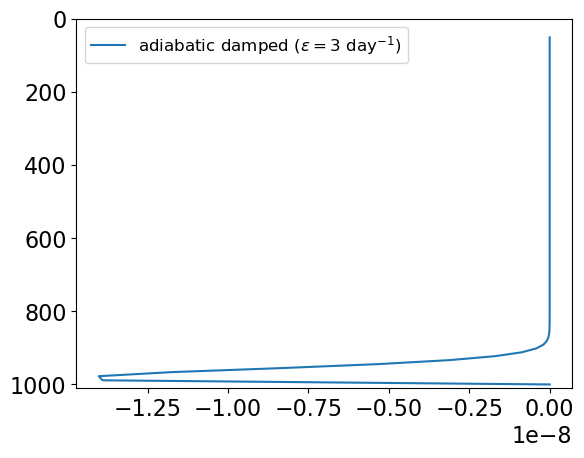

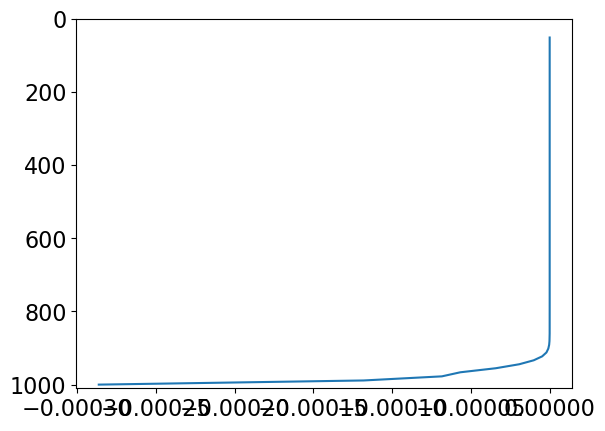

In [34]:
#plt.plot(np.real(w_sampleu),z_to_p_standard(zz_full),label='adiabatic')
plt.plot(np.real(w_sampleu_damped),z_to_p_standard(zz_full),label=r'adiabatic damped ($\epsilon =3$ day$^{-1}$)')

plt.ylim(1010,0.)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.real(Tprime_sampleu_damped),z_to_p_standard(zz_full),label=r'adiabatic damped ($\epsilon =3$ day$^{-1}$)')
plt.ylim(1010,0.)

## iteratively

In [17]:
def make_ddzmk2(z,lz2,k,U0,eps):
    """has nonuniform grid z"""
    n = len(z)
    
    lz2 = lz2/(1-1j*eps/(k*U0))**2
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if np.real(lz2[-1]) < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
        assert np.imag(mtop)>=0.
    
    D2 = make_D_fornberg(z,2,npoints=5) #Matrix of second differentiation
    A = D2 + np.diag(-k**2*np.ones(len(z)))
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)

    # second order one-sided finite difference for the top derivative
    dz1 = z[-1]-z[-2]
    dz2 = z[-2]-z[-3]
    beta = -(dz1+dz2)/(dz1*dz2)
    gamma = dz1/(dz2*(dz1+dz2))
    alpha = -beta-gamma

    A[-1,-3:] = np.array([gamma,beta,alpha])
    A[-1,-1] -=  1j* mtop    
    
    return A

In [43]:
kblow=1e-5

In [44]:
eps=1/1000

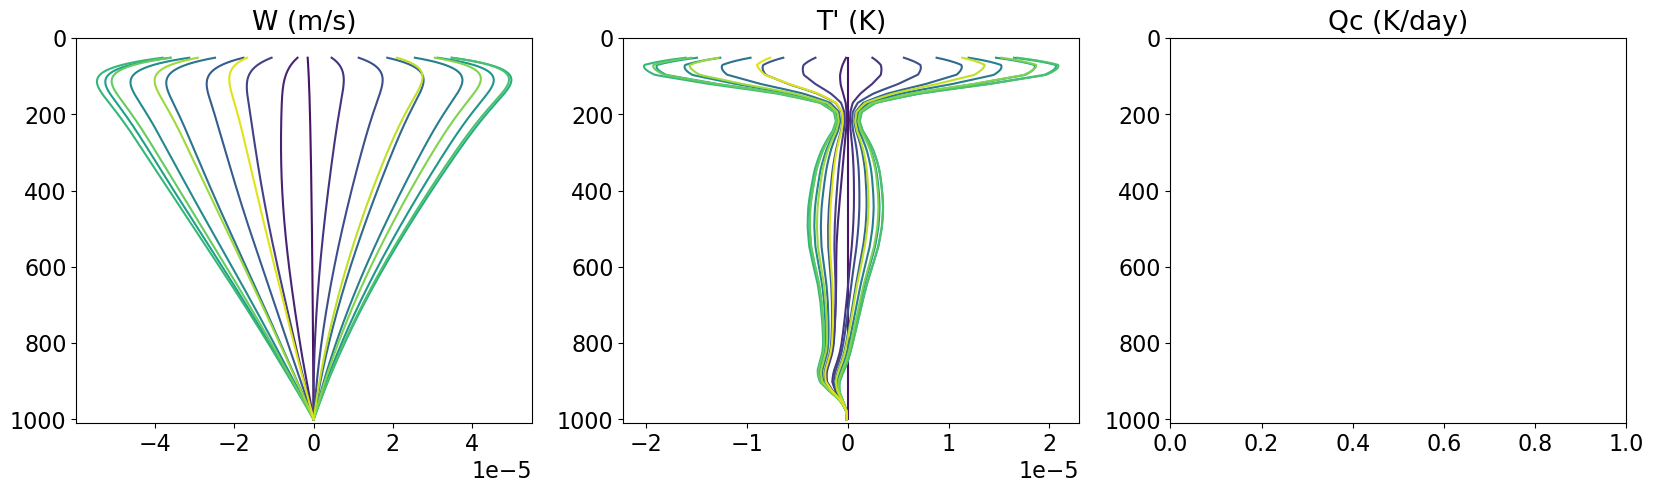

In [45]:
def iterate(niter):
    ddzmk2 = make_ddzmk2(zz_full,W10S300.N2TEST_full/U0**2,kblow,U0,eps)
    ww = np.zeros(len(zz_full))
    #ww,_,_,_,_  = coupled_gw_mode_damped(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,kblow,hhat0,U0,eps,0*Mkuang2,coupling='full',itp_matrices=None)

    ws=[];Ts=[]#;qs=[];Qcs=[];Qqs=[]
    for _ in range(niter):
        bprime = (-ww*W10S300.N2TEST_full)/(1j*kblow*U0+eps)
        maskout = np.ones(len(ww))
        maskout[0] = 0.; maskout[-1] = 0.
        bc = np.zeros(len(ww))*1j
        bc[0] = 1j*kblow*U0*hhat0
        ww = spl.solve(ddzmk2, -kblow**2/(1j*kblow*U0+eps)*bprime*maskout+bc)
        ws.append(ww);Ts.append(bprime)#;qs.append(qprime);Qcs.append(Qc)
    return ws,Ts#,qs,Qcs,Qqs

N=20
ws,Ts = iterate(N)#,qs,Qcs,Qqs
_,axs = plt.subplots(1,3,figsize=(20,5))

colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    axs[0].plot(np.real(ws[i]),z_to_p_standard(zz_full),color=colors[i])
    #axs[0].plot(np.imag(ws[i]),z_to_p_standard(zz_full),color=colors[i],linestyle='--')
    axs[1].plot(np.real(Ts[i]),z_to_p_standard(zz_full),color=colors[i])
    #axs[1].plot(np.imag(Ts[i]),z_to_p_standard(zz_full),color=colors[i],linestyle='--')
    #axs[2].plot(np.real(Qcs[i]),zz_full,color=colors[i])
    #axs[2].plot(np.imag(Qcs[i]),zz_full,color=colors[i],linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T' (K)")
axs[2].set_title('Qc (K/day)')
for ax in axs:
    ax.set_ylim(1010,0.)